In [74]:
import pandas as pd
import numpy as np 
import re

pd.set_option('display.max_colwidth', None)

f = open("HateSpeechDataset.csv",'r')
r_cols = ['tweet', 'hate', 'nums']
tweets = pd.read_csv("HateSpeechDataset.csv", names=r_cols, skiprows = 1)

word_dict = dict()
word_counter = 0

# Stop words list
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", 
              "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", 
              "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", 
              "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", 
              "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
              "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", 
              "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about",
              "against", "between", "into", "through", "during", "before", "after", 
              "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", 
              "under", "again", "further", "then", "once", "here", "there", "when", "where", 
              "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", 
              "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", 
              "very", "s", "t", "can", "will", "just", "don", "should", "now"]

counter2 = [0,0,0,0,0,0]
nGrams = [dict(),dict(),dict(),dict(),dict(),dict()]

In [75]:
# Function to clean text
def clean_text(text):
    clean_tweet = text + " "
    clean_tweet = re.sub(" http| https", "", clean_tweet)
    clean_tweet = re.sub("hyper text transfer protocol", "", clean_tweet)
    clean_tweet = re.sub("www .* com ", "", clean_tweet)
    clean_tweet = re.sub("www .* org ", "", clean_tweet)
    clean_tweet = re.sub("www .* net ", "", clean_tweet)
    clean_tweet = re.sub("www .* uk ", "", clean_tweet)
    clean_tweet = re.sub(" $", "", clean_tweet)
    return clean_tweet

# Map words to numbers
def number_words(text):
    global word_dict
    global word_counter
    new_numbers = []
    for i in text:
        if i in word_dict:
            new_numbers.append(word_dict[i])
        else:
            word_dict[i] = word_counter
            word_counter += 1
            new_numbers.append(word_dict[i])
    return new_numbers

# Remove stop words from text
def stop_word_removal(text):
    global stop_words
    return [word for word in text if word not in stop_words]

# Create n-grams from list
def nGrammify(text_nums, n):
    global nGrams
    global counter2
    myList = []
    for i in range(len(text_nums) - n + 1):
        nums = ""
        for j in range(n):
            nums = nums + "^" + str(text_nums[i+j])
        if nums in nGrams[n-1]:
            myList.append(nGrams[n-1][nums])
        else:
            nGrams[n-1][nums] = counter2[n-1]
            counter2[n-1] += 1
            myList.append(nGrams[n-1][nums])
    return myList

In [76]:
# Clean tweets
tweets['tweet'] = tweets['tweet'].apply(clean_text)

# Split tweets into tokens
tweets['splits'] = tweets['tweet'].str.split() 

# Map words to numbers
tweets['newNum'] = tweets['splits'].apply(number_words)

# Remove stop words
tweets['noStop'] = tweets['splits'].apply(stop_word_removal)

# 2_grams
tweets['2_grams'] = tweets['newNum'].apply(lambda x: nGrammify(x, 2))

# Clean data to csv
tweets.to_csv("finished_hate_speech.csv", index=False)

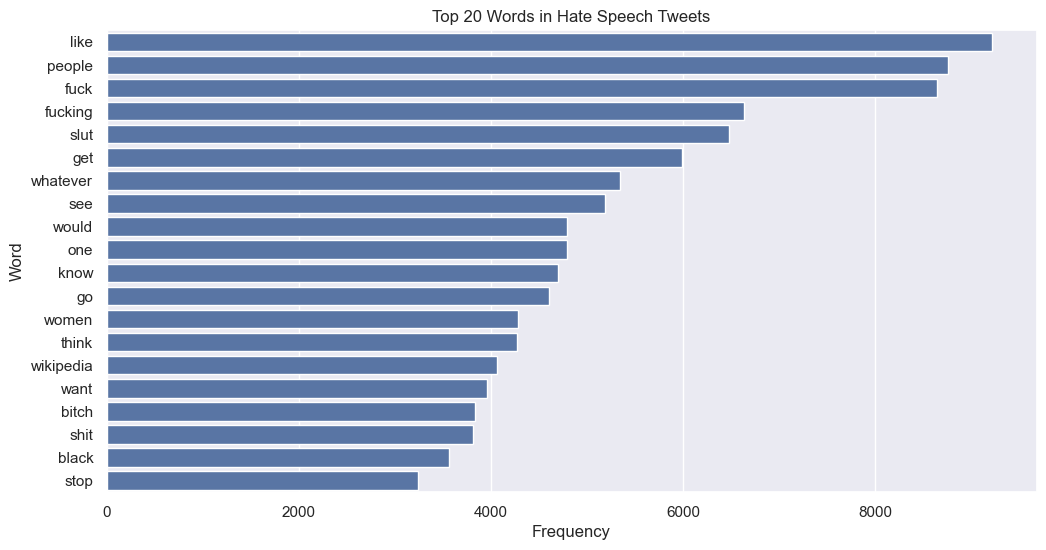

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set_theme(style="darkgrid")

# Hate speech tweets
hate_tweets = tweets[tweets['hate'] == "1"]

# Flatten list of words from noStop in hate tweets
all_hate_words = [word for sublist in hate_tweets['noStop'] for word in sublist]

# Count frequencies
hate_word_counts = Counter(all_hate_words)

# 20 most common words in hate tweets
top_hate_words = dict(hate_word_counts.most_common(20))

# Plot most common hate words
plt.figure(figsize=(12,6))
sns.barplot(x=list(top_hate_words.values()), y=list(top_hate_words.keys()))
plt.title("Top 20 Words in Hate Speech Tweets")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

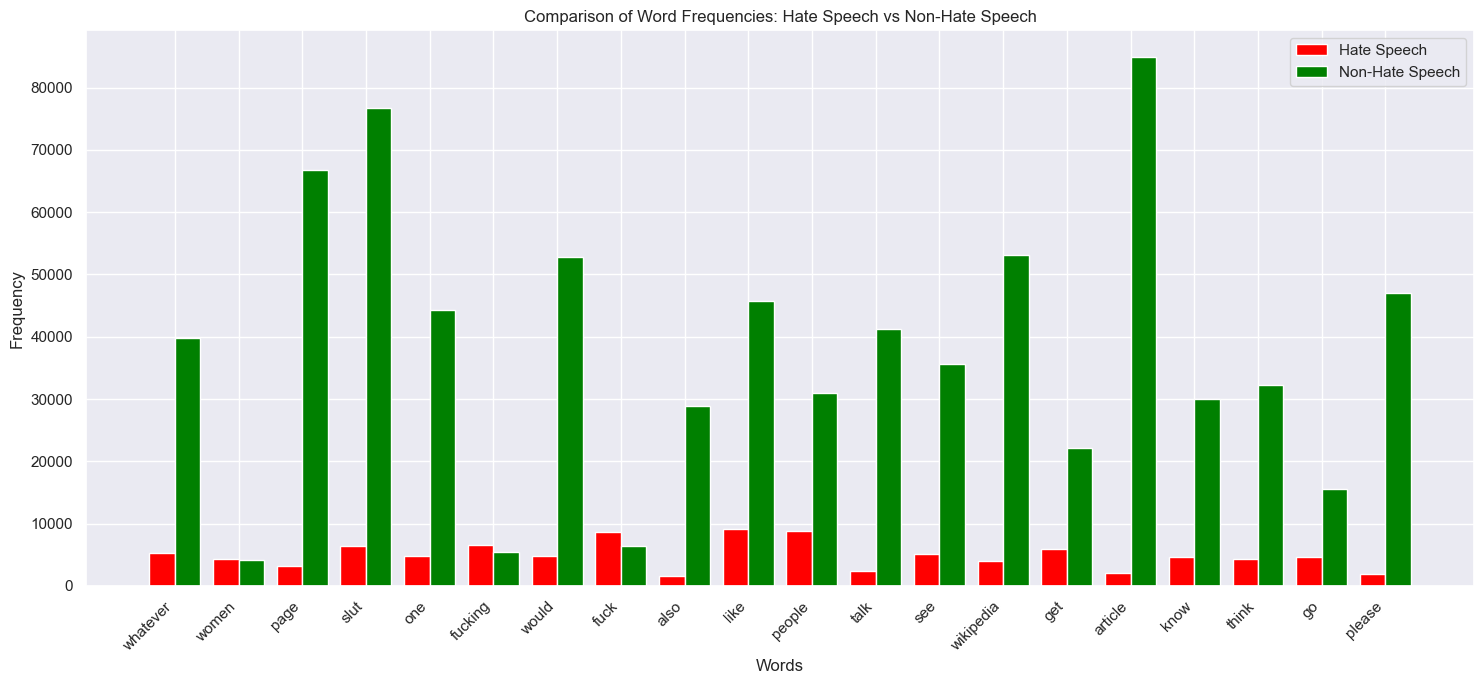

In [ ]:
# Separate hate and non-hate tweets
hate_tweets = tweets[tweets['hate'] == "1"]
non_hate_tweets = tweets[tweets['hate'] == "0"]

hate_words = [word for sublist in hate_tweets['noStop'] for word in sublist]
non_hate_words = [word for sublist in non_hate_tweets['noStop'] for word in sublist]

# Frequency counts
hate_counts = Counter(hate_words)
non_hate_counts = Counter(non_hate_words)

# Most common 15 words in each category
top_hate = [word for word, count in hate_counts.most_common(15)]
top_non_hate = [word for word, count in non_hate_counts.most_common(15)]

all_top_words = list(set(top_hate + top_non_hate))

# Frequencies for common words
hate_freqs = [hate_counts.get(word, 0) for word in all_top_words]
non_hate_freqs = [non_hate_counts.get(word, 0) for word in all_top_words]

x = np.arange(len(all_top_words))
width = 0.4

plt.figure(figsize=(15,7))
plt.bar(x - width/2, hate_freqs, width, label='Hate Speech', color='red')
plt.bar(x + width/2, non_hate_freqs, width, label='Non-Hate Speech', color='green')
plt.xticks(x, all_top_words, rotation=45, ha='right')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Hate Speech vs Non-Hate Speech")
plt.legend()
plt.tight_layout()
plt.show()

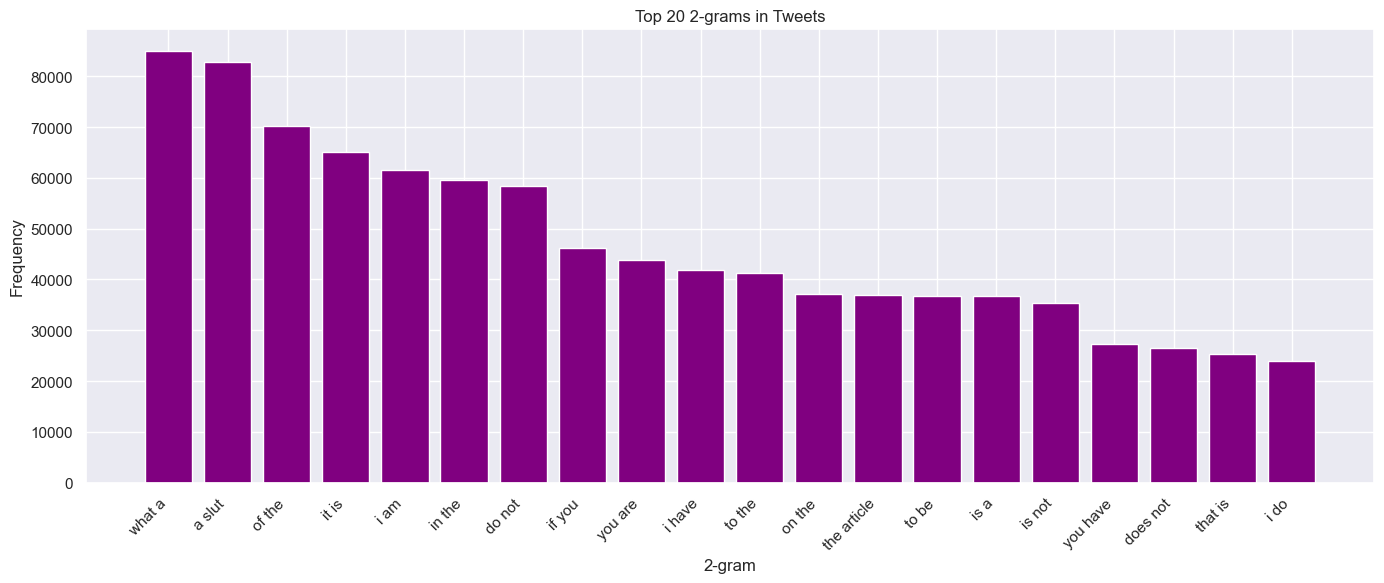

In [79]:
# Lookup for 2-gram IDs to strings
reverse_2gram = {v: k for k, v in nGrams[1].items()}

# Flatten 2-grams
all_2grams_ids = [ng_id for sublist in tweets['2_grams'] for ng_id in sublist]

# Count frequencies
ngram_counts = Counter(all_2grams_ids)

top_20 = ngram_counts.most_common(20)

labels = []
counts = []

for ng_id, count in top_20:
    ng_string = reverse_2gram[ng_id]
    
    word_ids = [int(x) for x in ng_string.split("^")[1:]]  # skip first empty
    
    # IDs to words
    words = []
    for wid in word_ids:
        for key, val in word_dict.items():
            if val == wid:
                words.append(key)
                break
    
    labels.append(" ".join(words))
    counts.append(count)

plt.figure(figsize=(14,6))
plt.bar(range(len(top_20)), counts, color='purple')
plt.xticks(range(len(top_20)), labels, rotation=45, ha='right')
plt.title("Top 20 2-grams in Tweets")
plt.xlabel("2-gram")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

C:\Users\alexc\AppData\Local\Temp\ipykernel_22724\1282383905.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hate_tweets['2grams_noStop'] = hate_tweets['noStop'].apply(lambda x: generate_ngrams(x, n=2))


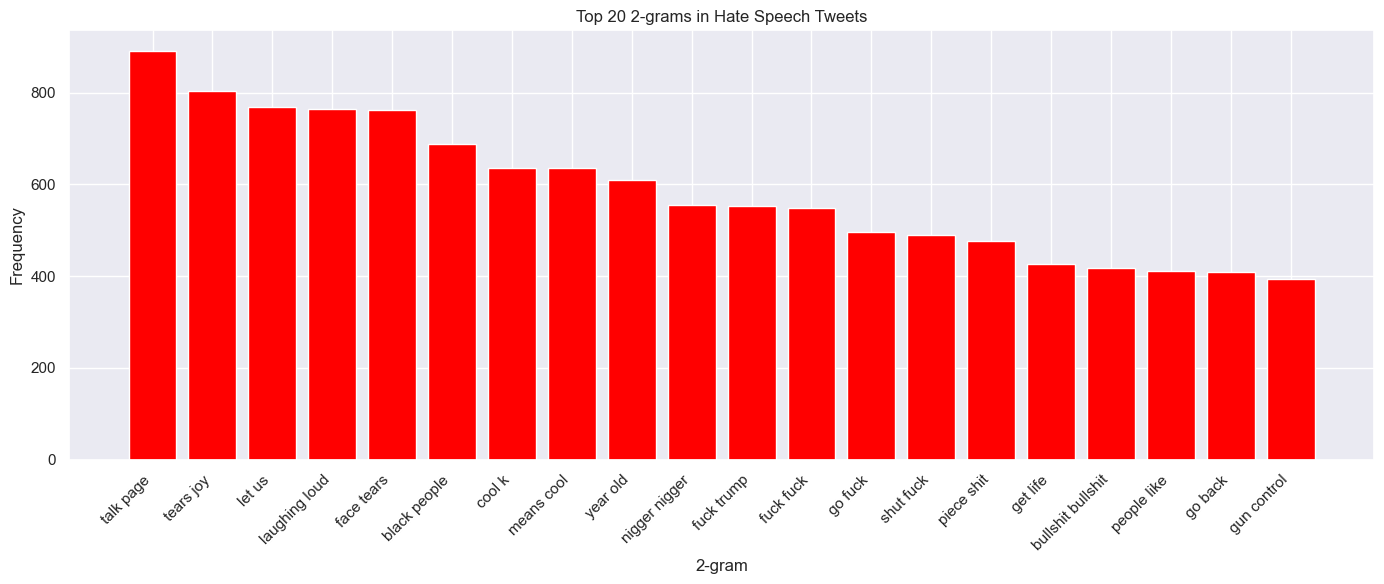

In [ ]:
# Filter hate speech tweets
hate_tweets = tweets[tweets['hate'] == "1"]

def generate_ngrams(words, n=2):
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]

# 2-grams without stop words
hate_tweets['2grams_noStop'] = hate_tweets['noStop'].apply(lambda x: generate_ngrams(x, n=2))

all_2grams_hate = [ng for sublist in hate_tweets['2grams_noStop'] for ng in sublist]

ngram_counts_hate = Counter(all_2grams_hate)

top_20_hate_ngrams = dict(ngram_counts_hate.most_common(20))

plt.figure(figsize=(14,6))
plt.bar(range(len(top_20_hate_ngrams)), top_20_hate_ngrams.values(), color='red')
plt.xticks(range(len(top_20_hate_ngrams)), top_20_hate_ngrams.keys(), rotation=45, ha='right')
plt.title("Top 2-grams in Hate Speech Tweets")
plt.xlabel("2-gram")
plt.ylabel("Amount")
plt.tight_layout()
plt.show()

=== Decision Tree (max_depth=6) Metrics ===
Accuracy:  0.8260441305122639
Precision: 0.6146922889807833
Recall:    0.09094180731996977


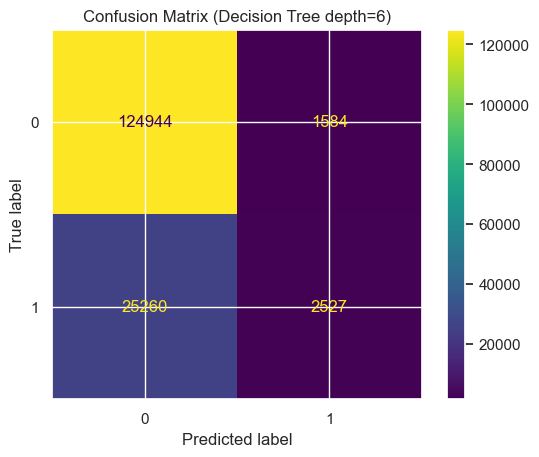

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tweets = tweets[tweets['hate'].isin(['0', '1'])]

labels = tweets['hate'].astype(int)

tweets['joined_tokens'] = tweets['noStop'].apply(lambda toks: " ".join(toks) if isinstance(toks, list) else "")

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,1))
X = vectorizer.fit_transform(tweets['joined_tokens'])
feature_names = vectorizer.get_feature_names_out()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.35, random_state=42)

# max depth 6
dt6 = tree.DecisionTreeClassifier(max_depth=6, random_state=42)
dt6 = dt6.fit(X_train, y_train)

predictions_binary = dt6.predict(X_test)

cm = metrics.confusion_matrix(y_test, predictions_binary)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt6.classes_)

print("Decision Tree")
print("Accuracy: ", metrics.accuracy_score(y_test, predictions_binary))
print("Precision:", metrics.precision_score(y_test, predictions_binary, zero_division=0))
print("Recall:   ", metrics.recall_score(y_test, predictions_binary, zero_division=0))

disp.plot()
plt.title("Confusion Matrix")
plt.show()

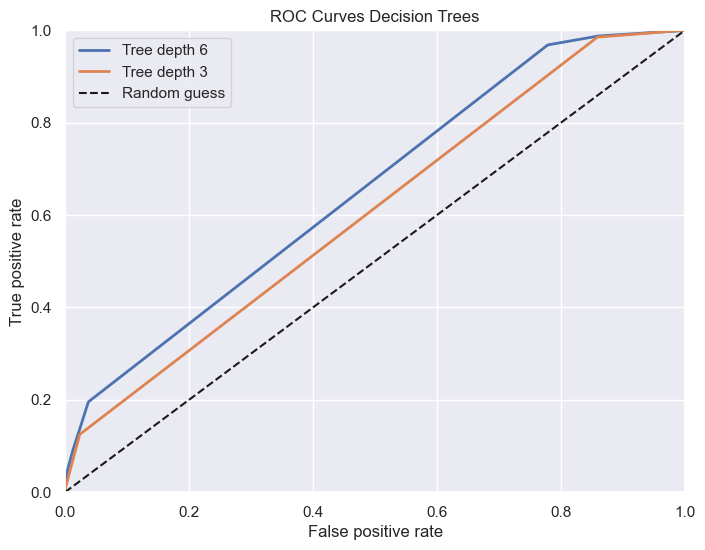

In [ ]:
# max depth 3
dt3 = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
dt3 = dt3.fit(X_train, y_train)

predictions_proba = dt6.predict_proba(X_test)
predictions_proba2 = dt3.predict_proba(X_test)

# CROC curves
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_proba[:, 1], pos_label=1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, predictions_proba2[:, 1], pos_label=1)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2.0, label="Tree depth 6")
plt.plot(fpr2, tpr2, linewidth=2.0, label="Tree depth 3")

plt.plot([0, 1], [0, 1], "k--", label="Random guess")

plt.xlabel("False positive")
plt.ylabel("True positive")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.title("ROC Curves for decision trees")
plt.show()

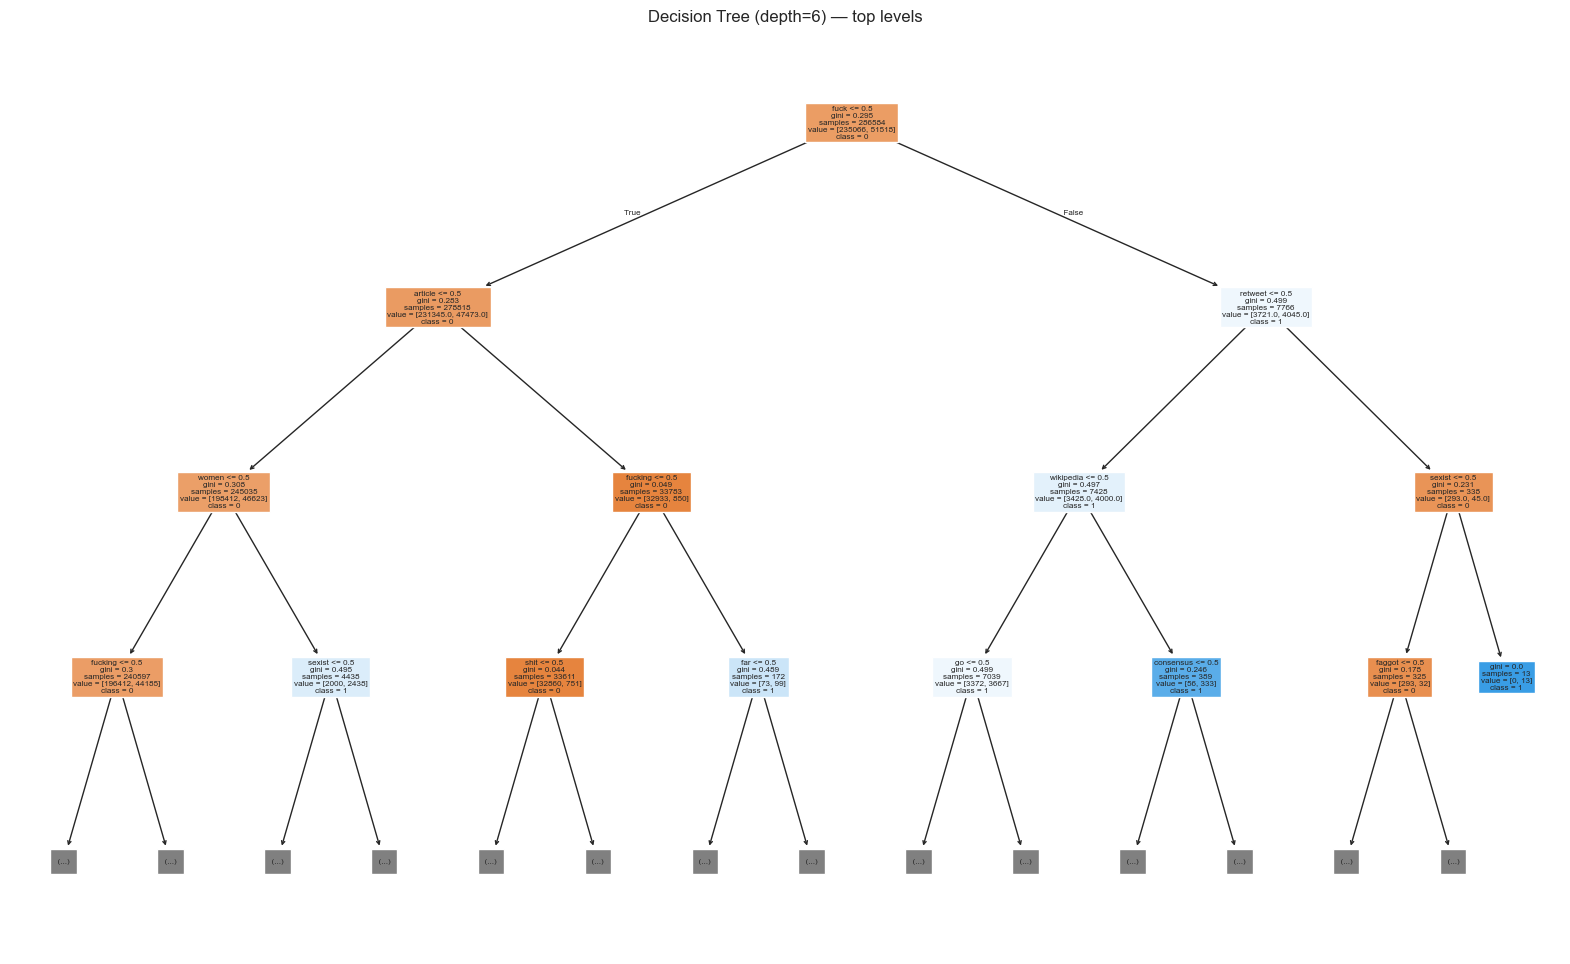

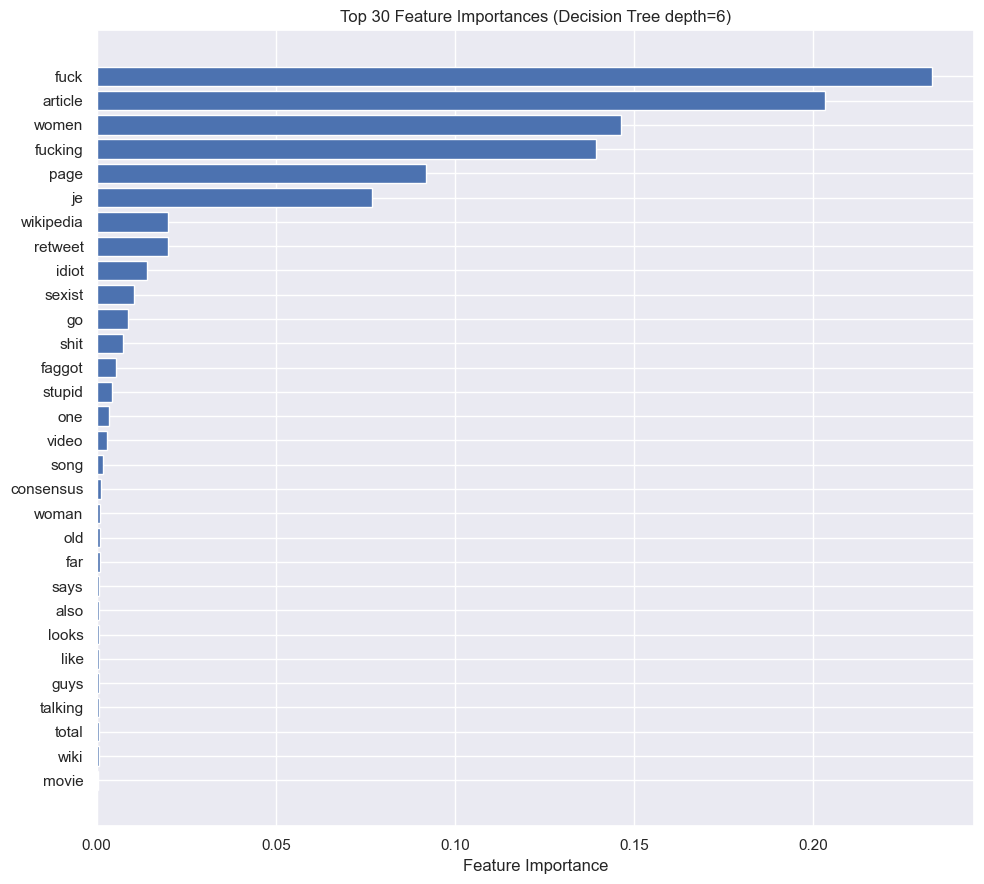


Top features with non-zero importance (feature : importance):
fuck : 0.2332
article : 0.2032
women : 0.1463
fucking : 0.1393
page : 0.0919
je : 0.0769
wikipedia : 0.0200
retweet : 0.0199
idiot : 0.0141
sexist : 0.0103
go : 0.0088
shit : 0.0074
faggot : 0.0055
stupid : 0.0044
one : 0.0034
video : 0.0029
song : 0.0018
consensus : 0.0013
woman : 0.0011
old : 0.0008
far : 0.0008
says : 0.0008
also : 0.0008
looks : 0.0007
like : 0.0007
guys : 0.0006
talking : 0.0006
total : 0.0006
wiki : 0.0006
movie : 0.0004


In [ ]:
# decision tree
plt.figure(figsize=(20,12))
plot_tree(dt6, feature_names=feature_names, class_names=['0','1'], filled=True, max_depth=3)
plt.title("Decision Tree")
plt.show()

# Feature importance
import numpy as np

importances = dt6.feature_importances_
nonzero_idx = np.where(importances > 0)[0]
top_k = 30

if len(nonzero_idx) == 0:
    print("No feature importances")
else:
    top_indices = np.argsort(importances)[-top_k:]
    top_indices = top_indices[np.argsort(importances[top_indices])]

    top_features = feature_names[top_indices]
    top_importances = importances[top_indices]

    plt.figure(figsize=(10, max(4, len(top_features)*0.3)))
    plt.barh(range(len(top_features)), top_importances)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel("Feature Importance")
    plt.title(f"Top {len(top_features)} Feature Importances")
    plt.tight_layout()
    plt.show()
